# Unsupervised Learning: KDE and Clustering

Kernel-Density Estimation (KDE) and clustering are exploratory data analysis techniques. This notebook showcases how to use these techniques to extract information on how data is distributed.

For the sake of simplicity, we consider a two-dimensional data set, but both methods can be applied to data of any dimensionality.

We will create some clusters in the x-y plane and (1) use KDE to visualize those clusters and (2) use clustering methods to recover the clusters from a noisy background.

## Data Generation

We create a random distribution of clusters and background noise.

In [1]:
import numpy as np
np.random.seed(20) # we manually set a seed to make results reproducible

In [2]:
# map dimensions
m, n = 1000, 1000 # dimensions in x and y

# parametrization
n_clusters = 3 # number of clusters
n_per_cluster = 50 # number of data points per cluster
n_background = 200 # number of background data points

# create background noise
coo = np.empty((2, n_clusters*n_per_cluster+n_background))
coo[0] = np.random.randint(low=0, high=m, size=len(coo[0]), dtype=np.int64)
coo[1] = np.random.randint(low=0, high=n, size=len(coo[1]), dtype=np.int64)
coo_target = np.zeros(n_clusters*n_per_cluster+n_background) # id labels: background has id=0

# add clusters
for i in range(n_clusters):
    # randomize cluster properties
    scale = np.random.rand()*min([m, n])/15 # cluster extent = 1 standard deviation
    center_x = np.random.randint(low=50, high=m-50) # center x coordinate
    center_y = np.random.randint(low=50, high=n-50) # center y coordinate
    
    # create cluster data points
    coo[0, n_background+i*n_per_cluster:n_background+(i+1)*n_per_cluster] = np.random.normal(
        loc=center_x, scale=scale, size=n_per_cluster).astype(int)
    coo[1, n_background+i*n_per_cluster:n_background+(i+1)*n_per_cluster] = np.random.normal(
        loc=center_y, scale=scale, size=n_per_cluster).astype(int)

    # store cluster id for each coordinate
    coo_target[n_background+i*n_per_cluster:n_background+(i+1)*n_per_cluster] = i+1

# clip outliers (might be generated by clusters)
coo_target = coo_target[(coo[0] > 0) & (coo[0] < m) & (coo[1] > 0) & (coo[1] < n)]
coo = coo[:, (coo[0] > 0) & (coo[0] < m) & (coo[1] > 0) & (coo[1] < n)]

Let's plot the resulting distribution

In [3]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5))
for i in range(n_clusters+1):
    ax.scatter(coo[0, coo_target==i], coo[1, coo_target==i], marker='.',
               label='background' if i==0 else "cluster {}".format(i))
f.legend()

The plot above represents the data well and for a human it is usually no problem estimating densities and identifying over-densities in the distribution - even if all data points had the same color. 

The typical method to measure densities is to use a [histogram](https://en.wikipedia.org/wiki/Histogram). However, the density distributions resulting from histograms depend highly on the bin size and the locations of the bin edges. Furthermore, histograms are stepwise constant functions and hence typically not smooth and differentiable.

A better way of estimating densities is using the following method.

## Kernel Density Estimation

Kernel Density Estimation is a non-parametric method to estimate the probability density function of one (or more) random variable. 

In the one-dimensional case, the method turns a distribution of (discrete) data points $\vec x = \{x_1, x_2, x_3, ...\}$, which are drawn from a probability distribution $h$, into a function $$f(x) = \frac{1}{n} \sum_i^n K(x-x_i, b).$$ $K$ is here a non-negative kernel function that smoothens the resulting distribution. The kernel function has a bandwidth parameter, $b$, that is a measure for the width of each data point in the resulting probability density distribution and to some extent its "resolution". In order to obtain a valid probability density function from KDE, it has to be normalized such that $\int f(x)\, dx = 1$

Typical KDE kernels include the tophat function and the Gaussian. The big difference between KDE and a simple histogram is that KDE replaces every data point with the kernel function. If kernel functions from different data points overlap, the function values are summed up, leading to a much smoother probability density function than is obtained from a histogram.

Let's apply the [KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn-neighbors-kerneldensity) class available in scikit-learn to our data.

In [4]:
from sklearn.neighbors.kde import KernelDensity

We define a `KernelDensity` instance with a specific bandwidth - this is the most important parameter of KDE. This parameter has to be tuned to the data, which requires some iterations.

Since we're dealing with two-dimensional data, we have to rearrange the data in such a way that we end up with an array of x-y tuples, looking something like this: `[ [x1, y1], [x2, y2], [x3, y3], ...]`

In [5]:
kde = KernelDensity(bandwidth=50)
kde.fit(coo.transpose())

KernelDensity(algorithm='auto', atol=0, bandwidth=50, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

`kde` is now trained and can evaluate probability density values for given positions in the x-y plane using the  [score_samples](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity.score_samples) method. Note that this method returns log-likelihoods, so we have to apply the exponential function to get real probability densities:

In [6]:
np.exp(kde.score_samples([(500, 500)]))

array([5.02515615e-07])

This is just an example value for a random position.

Now we can apply the same method on every position in a grid spanning the x-y plane. We describe this plane using a [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html).

In [7]:
n_xbins = 100j # number of bins in x (as a complex number)
n_ybins = 100j # number of bins in y (as a complex number)

# create meshgrid in x and y
xx, yy = np.mgrid[0:m:n_xbins, 
                  0:n:n_ybins]

# rearrange xx and yy in an array of x-y tuples
xy = np.vstack([xx.ravel(), yy.ravel()]).transpose()

# obtain probability densities
p = np.exp(kde.score_samples(xy))

Let's plot the probability density distribution; remember that we have to reshape `p`:

Text(0.5, 1.0, 'KDE Results')

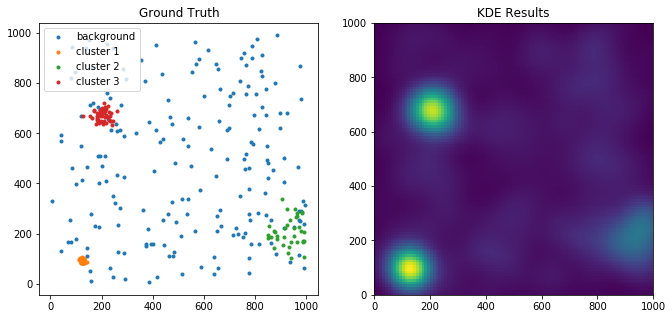

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))

# draw data points and color them according to their cluster affiliation (background will be red)
for i in range(n_clusters+1):
    ax1.scatter(coo[0, coo_target==i], coo[1, coo_target==i], marker='.',
              label='background' if i==0 else "cluster {}".format(i))
    
# draw probability density distribution
ax2.pcolormesh(xx, yy, p.reshape(xx.shape))

ax1.set_title('Ground Truth')
ax1.legend()

ax2.set_title('KDE Results')

### Try This: Play with the bandwidth

To get a useful probability density distribution from KDE, the `bandwidth` parameter has to be chosen properly. Low values lead to very localized and peaked distributions, whereas large values lead to "washed out" and flat distributions. Keep in mind that in the case of a Gaussian kernel, `bandwidth` simply denotes the standard deviation used for every kernel.

### Try This: Try other kernels

Try a tophat kernel and see how the distribution becomes less smooth.

### How to use KDE

* select a kernel (good first-guess: Gaussian)
* tune bandwidth for smooth probability density function and contrast

## k-Means Clustering

We will now try to identify clusters using two different methods. Let's start with $k$-Means clustering.

$k$-Means clustering is very simple. It tries to identify $k$ (a parameter provided to the method) different clusters in the data using an iterative algorithm:
1. pick $k$ random data points and define those as cluster centers
2. assign each data point to that cluster that is closest
3. recalculate cluster centers as the mean in each dimension
4. break if maximum number of iterations or some other termination trigger has been reached; repeat step 2, if not

In [9]:
from sklearn.cluster import KMeans

In [10]:
model = KMeans(n_clusters, random_state=19)
model.fit(coo.transpose())
pred = model.predict(coo.transpose())

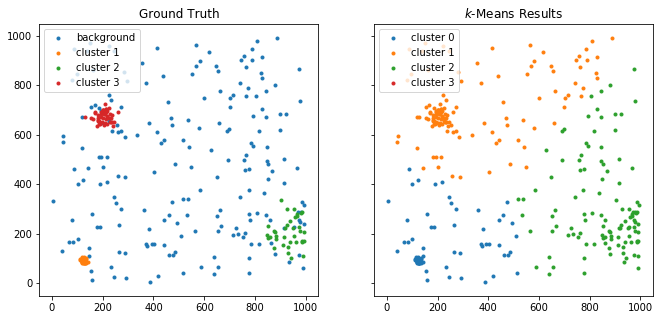

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 5))

for i in range(n_clusters+1):
    ax1.scatter(coo[0, coo_target==i], coo[1, coo_target==i], marker='.',
               label='background' if i==0 else "cluster {}".format(i))
    ax2.scatter(coo[0, pred==i], coo[1, pred==i], marker='.', 
               label="cluster {}".format(i))

ax1.set_title('Ground Truth')
ax1.legend()

ax2.set_title(r'$k$-Means Results')
ax2.legend()

$k$-Means does identify clusters that are very similar to the actual clusters (the cluster naming order is different, since $k$-Means picks a random order). However, one important observation is that $k$-Means also assigns background data points to the clusters it found - there is no concept of unaffiliated data points in $k$-Means.

### Caveat: Cluster shapes
    
$k$-Means assigns cluster affiliation based on the shortest distance to the next cluster. Depending on the distance metric being used, this usually forces radially symmetric cluster shapes. What if we are trying to identify irregularly shaped clusters? 

In that case, the algorithm will most likely not find the clusters we are looking for, but some other representation (see also: "Scaling matters"). In the case of irregularly shaped clusters, other clustering methods (e.g., DBSCAN) might be more successful.

### Try This: increase the number of clusters to be found by k-Means

What if you try to find more clusters than there actually are in the data set? Most likely, the algorithm will try to split clusters. Hence, human interference is necessary to find the correct number of clusters.

###  Caveat: Scaling matters

What if we have our data dispersed in a two-dimensional plane in which the x-axis ranges from 0 to 1 but the y-axis from 0 to 100? 

Think again about how clusters are identified: based on the shortest distance to the next cluster. If this distance is calculated using a Euclidean metric, the large discrepancy in scale in both dimensions will lead to significant distortions and most likely the method will pick incorrect clusters. 

**When applying $k$-Means clustering, the value scales in all dimensions should cover similar ranges.**

To prevent scaling issues, scikit-learn provides [scaler](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) functions that scale value ranges based on MinMax, variances, or Gaussian distributions.

### How to use $k$-Means clustering

* make sure that the data is scaled
* estimate the number of clusters in the sample (e.g., using KDE)
* run the algorithm
* tune number of clusters, if necessary

## DBSCAN

Density-Based Spatial Clustering of Applications with Noise ([DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)) is a non-parametric clustering algorithm that is more flexible than $k$-Means in that the user does not have to make assumptions on the number of clusters in the data set. Instead, DBSCAN will find clusters (high-density regions) of similar density.

DBSCAN's parameters are $\epsilon$ and the minimum number of data points that are required to form a cluster (minimum sample size). $\epsilon$ is the maximum distance measure within which data points are considered to be part of the same cluster. The algorithm works as follows:
1. start with a random data point that has not yet been visited
2. from this data point, iteratively find all data points within distance $\epsilon$
3. if the mininum sample size in neighbors within $\epsilon$ from each other is reached, define this group as a cluster; if not, disregard those data points as noise
4. break if all data points have been visited; repeat step 1, if not

In [12]:
from sklearn.cluster import DBSCAN

We use $\epsilon$=50 and use a minimum number of data points to form a cluster of 10 to fit and predict cluster affiliation.

In [13]:
model = DBSCAN(eps=50, min_samples=10)
pred = model.fit_predict(coo.transpose())

We plot the results:

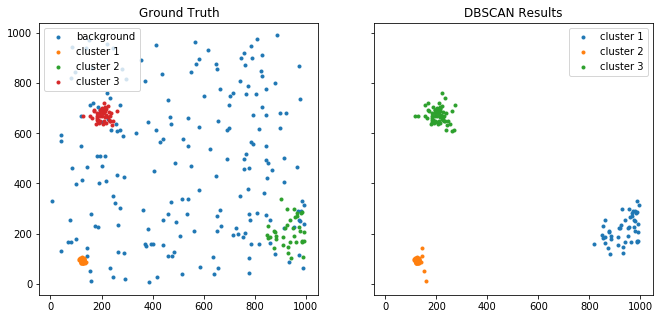

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11, 5))

for i in range(n_clusters+1):
    ax1.scatter(coo[0, coo_target==i], coo[1, coo_target==i], marker='.', 
                label='background' if i==0 else "cluster {}".format(i))
    if len(coo[0, pred==i]) > 0:
        ax2.scatter(coo[0, pred==i], coo[1, pred==i], marker='.',
                   label="cluster {}".format(i+1))
ax1.set_title('Ground Truth')
ax1.legend()

ax2.set_title('DBSCAN Results')
ax2.legend()

With carefully selected values for $\epsilon$ and the minimum sample size, we are not only able to identify the correct number of clusters and their approximate shapes, but we are also able to minimize pollution caused by background data points.

### Try This: What happens if $\epsilon$ and the minimum sample size are not chosen properly?

In that case, the number of clusters you can find and the pollution with background source will vary significantly. Careful parameter-tuning is crucial for the success of DBSCAN!

### How to use DBSCAN
* make sure data is scaled
* carefully tune $\epsilon$ and the minimum sample size

## Additional resources

* [density estimation](https://scikit-learn.org/stable/modules/density.html) article in scikit-learn docs
* [sklearn clustering methods comparison](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)